# Interface Reactions

This notebook shows how to
* Obtain information about interface reactions between two solid substances in contact, and
* Plot reaction energy as a function of mixing ratio.

We use the [Materials Project API](https://github.com/materialsproject/mapidoc) to obtain energies of compounds.

In [ ]:
# Uncomment the subsequent lines in this cell to install dependencies for Google Colab.
# !pip install pymatgen==2022.7.19

In [ ]:
from pymatgen.analysis.interface_reactions import InterfacialReactivity
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram, PhaseDiagram
from pymatgen.core import Composition, Element
from pymatgen.ext.matproj import MPRester

%matplotlib inline

# Initialize the REST API interface. You may need to put your own API key in as an arg.
mpr = MPRester()

First, set the values of the two reactants. Optionally, simulate the case where the reaction system is in contact with an elemental reservoir.

Because the methodology here is to generate a pseudo-binary phase stability diagram of two reactants as a function of mixing ratio, the addition of an elemental reservoir implies construction of a so-called _grand potential phase diagram_.

In [ ]:
# Chemical formulae for two solid reactants.
reactant1 = "LiCoO2"
reactant2 = "Li3PS4"

# Is the system open to an elemental reservoir?
grand = True

if grand:
    # Element in the elemental reservoir.
    open_el = "Co"
    # Relative chemical potential vs. pure substance. Must be non-positive.
    relative_mu = -1

Now, compile the critical reaction information:

In [ ]:
# Get the compositions of the reactants
comp1 = Composition(reactant1)
comp2 = Composition(reactant2)

# Gather all elements involved in the chemical system.
elements = [e.symbol for e in comp1.elements + comp2.elements]
if grand:
    elements.append(open_el)
elements = list(set(elements))  # Remove duplicates

# Get all entries in the chemical system
entries = mpr.get_entries_in_chemsys(elements)

# Build a phase diagram using these entries.
pd = PhaseDiagram(entries)

# For an open system, include the grand potential phase diagram.
if grand:
    # Get the chemical potential of the pure subtance.
    mu = pd.get_transition_chempots(Element(open_el))[0]
    # Set the chemical potential in the elemental reservoir.
    chempots = {open_el: relative_mu + mu}
    # Build the grand potential phase diagram
    gpd = GrandPotentialPhaseDiagram(entries, chempots)
    # Create InterfacialReactivity object.
    interface = InterfacialReactivity(
        comp1,
        comp2,
        gpd,
        norm=True,
        include_no_mixing_energy=True,
        pd_non_grand=pd,
        use_hull_energy=False,
    )
else:
    interface = InterfacialReactivity(
        comp1,
        comp2,
        pd,
        norm=True,
        include_no_mixing_energy=False,
        pd_non_grand=None,
        use_hull_energy=False,
    )

From here, you can plot reaction energy versus mixing ratio as below. Note that the mixing ratio is between the normalized compositions of the reactants.

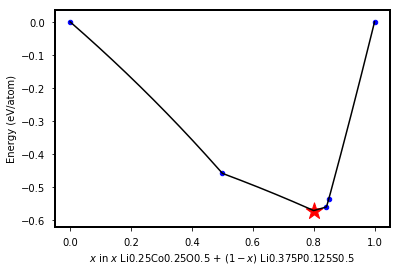

In [ ]:
plt = interface.plot()

In [ ]:
from collections import OrderedDict

import pandas as pd

critical_rxns = [
    OrderedDict(
        [
            ("Atomic fraction", round(ratio, 3)),
            ("Reaction equation", rxn),
            ("E$_{rxt}$ per mol equation (kJ/mol)", round(rxn_energy, 1)),
            ("E$_{rxt}$ per reactant atom (eV/atom)", round(reactivity, 3)),
        ]
    )
    for _, ratio, reactivity, rxn, rxn_energy in interface.get_kinks()
]
interface_reaction_table = pd.DataFrame(critical_rxns)
interface_reaction_table

,Atomic fraction,Reaction equation,E$_{rxt}$ per mol equation (kJ/mol),E$_{rxt}$ per reactant atom (eV/atom)
0,0.000,Li3PS4 -> Li3PS4,0.0,0.000
1,0.500,0.3333 Li3PS4 + 0.6667 LiCoO2 -> 0.1667 Co + 0...,-206.4,-0.458
2,0.800,0.1111 Li3PS4 + 0.8889 LiCoO2 -> 0.8889 Co + 0...,-195.9,-0.571
3,0.842,0.08571 Li3PS4 + 0.9143 LiCoO2 -> 0.9143 Co + ...,-185.3,-0.560
4,0.850,0.08108 Li3PS4 + 0.9189 LiCoO2 -> 0.8649 Co + ...,-175.8,-0.535
5,1.000,LiCoO2 -> LiCoO2,-0.0,-0.000


You can also obtain the mixing ratio between the original compositions, i.e. mol fraction of the first reactant.

In [ ]:
import numpy as np

interface_reaction_table["Molar fraction"] = pd.Series(
    np.round(interface.get_critical_original_kink_ratio(), 3)
)
interface_reaction_table

,Atomic fraction,Reaction equation,E$_{rxt}$ per mol equation (kJ/mol),E$_{rxt}$ per reactant atom (eV/atom),Molar fraction
0,0.000,Li3PS4 -> Li3PS4,0.0,0.000,0.000
1,0.500,0.3333 Li3PS4 + 0.6667 LiCoO2 -> 0.1667 Co + 0...,-206.4,-0.458,0.667
2,0.800,0.1111 Li3PS4 + 0.8889 LiCoO2 -> 0.8889 Co + 0...,-195.9,-0.571,0.889
3,0.842,0.08571 Li3PS4 + 0.9143 LiCoO2 -> 0.9143 Co + ...,-185.3,-0.560,0.914
4,0.850,0.08108 Li3PS4 + 0.9189 LiCoO2 -> 0.8649 Co + ...,-175.8,-0.535,0.919
5,1.000,LiCoO2 -> LiCoO2,-0.0,-0.000,1.000


Note that the reaction equations are `Reaction` objects suitable for structured analysis:

In [ ]:
rxn = critical_rxns[2]["Reaction equation"]
print(rxn)
print(type(rxn))

0.1111 Li3PS4 + 0.8889 LiCoO2 -> 0.8889 Co + 0.3333 Li2SO4 + 0.1111 Li2S + 0.1111 Li3PO4
<class 'pymatgen.analysis.reaction_calculator.Reaction'>


In [ ]:
# Get interface reaction information for reactants LiCoO2 and Li3PS4 in open system to Co.
kinks_from_API = mpr.get_interface_reactions(
    "LiCoO2", "Li3PS4", open_el="Co", relative_mu=-1, use_hull_energy=False
)

# Get inforamtion for the second critical reaction.
print(kinks_from_API[1])

{'ratio_atomic': 0.5000000000000001, 'ratio_molar': 0.6666666666666666, 'energy': -0.45837463535714296, 'rxn': Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 + Li3PO4, 'rxn_str': '0.333 Li3PS4 + 0.667 LiCoO2 -> 0.167 Co + 0.333 Li2S + 0.5 CoS2 + 0.333 Li3PO4', 'rxn_energy_sigdig': '-0.4584', 'rxn_energy_sigdig_kJmol': '-206.4', 'energy_per_mol_rxn_kJmol': -206.389932955848}


The critical reaction information from REST API should be the same as in the previous table:

In [ ]:
critical_rxns_from_API = [
    OrderedDict(
        [
            ("Atomic fraction", round(reaction["ratio_atomic"], 3)),
            ("Molar fraction", round(reaction["ratio_molar"], 3)),
            ("Reaction equation", reaction["rxn_str"]),
            (
                "E$_{rxt}$ per mol equation (kJ/mol)",
                round(float(reaction["rxn_energy_sigdig_kJmol"]), 1),
            ),
            ("E$_{rxt}$ per reactant atom (eV/atom)", round(reaction["energy"], 3)),
        ]
    )
    for reaction in kinks_from_API
]
pd.DataFrame(critical_rxns_from_API)

,Atomic fraction,Molar fraction,Reaction equation,E$_{rxt}$ per mol equation (kJ/mol),E$_{rxt}$ per reactant atom (eV/atom)
0,0.000,0.000,Li3PS4 -> Li3PS4,0.0,0.000
1,0.500,0.667,0.333 Li3PS4 + 0.667 LiCoO2 -> 0.167 Co + 0.33...,-206.4,-0.458
2,0.800,0.889,0.111 Li3PS4 + 0.889 LiCoO2 -> 0.889 Co + 0.33...,-195.9,-0.571
3,0.842,0.914,0.086 Li3PS4 + 0.914 LiCoO2 -> 0.914 Co + 0.11...,-185.3,-0.560
4,0.850,0.919,0.081 Li3PS4 + 0.919 LiCoO2 -> 0.865 Co + 0.05...,-175.8,-0.535
5,1.000,1.000,LiCoO2 -> LiCoO2,-0.0,-0.000
